# Prepare the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.model_selection import train_test_split

In [2]:
credits = pd.read_csv('/Users/xhan/OneDrive/dataset/tmdb-5000-movie-dataset/tmdb_5000_credits.csv')
movies = pd.read_csv('/Users/xhan/OneDrive/dataset/tmdb-5000-movie-dataset/tmdb_5000_movies_nonull.csv')

### Merge two data sets

In [3]:
movies_sub = movies.loc[:, ['id', 'original_title', 'genres']]
credits_sub = credits.loc[:, ['movie_id', 'cast']].rename(columns={'movie_id':'id'})
df = movies_sub.merge(credits_sub)

In [4]:
df.shape

(4799, 4)

In [5]:
df.head(5)

,id,original_title,genres,cast
0,19995,Avatar,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""..."
1,285,Pirates of the Caribbean: At World's End,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa..."
2,206647,Spectre,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr..."
3,49026,The Dark Knight Rises,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba..."
4,49529,John Carter,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""cast_id"": 5, ""character"": ""John Carter"", ""c..."


In [6]:
# drop movies with no cast/genre info
for i, row in df.iterrows():
    if row['genres'] == '[]':
        df.drop(i, inplace=True)
df = df.dropna()

In [7]:
df.shape

(4772, 4)

### Briefing of cast and genres

In [8]:
# All cast: # of movies
cast_all = defaultdict(int)

for item in df.cast:
    for p in json.loads(item):
        cast_all[p['name']] += 1

sorted(cast_all.items(), key=lambda x: x[1], reverse=True)[:10]

[('Samuel L. Jackson', 67),
 ('Robert De Niro', 57),
 ('Bruce Willis', 51),
 ('Matt Damon', 48),
 ('Morgan Freeman', 46),
 ('Steve Buscemi', 43),
 ('Liam Neeson', 41),
 ('Johnny Depp', 40),
 ('Owen Wilson', 40),
 ('John Goodman', 39)]

In [9]:
# All genres
all_genres = defaultdict(int)

for row in df.genres:
    for item in json.loads(row):
        all_genres[item['name']] += 1

genres_list = sorted(all_genres.items(), key=lambda x: x[1], reverse=True)
genres_list

[('Drama', 2296),
 ('Comedy', 1722),
 ('Thriller', 1274),
 ('Action', 1154),
 ('Romance', 894),
 ('Adventure', 790),
 ('Crime', 696),
 ('Science Fiction', 535),
 ('Horror', 519),
 ('Family', 513),
 ('Fantasy', 424),
 ('Mystery', 348),
 ('Animation', 234),
 ('History', 197),
 ('Music', 185),
 ('War', 144),
 ('Documentary', 108),
 ('Western', 82),
 ('Foreign', 34),
 ('TV Movie', 8)]

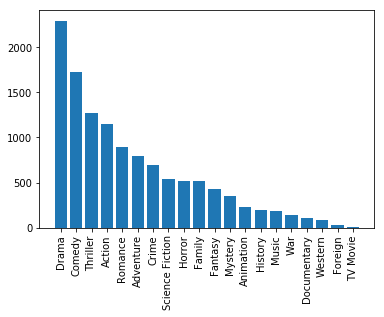

In [10]:
plt.bar(x = [x[0] for x in genres_list], height = [y[1] for y in genres_list])
plt.xticks(rotation=90)
plt.show()

### Modify df

In [11]:
def extract_gender(cell):
    """Extract cast gender"""
    female = 0
    male = 0
    for item in json.loads(cell):
        if item['gender'] == 1: female += 1
        elif item['gender'] == 2: male += 1
        else: continue
            
    return female, male

In [12]:
def modify_df(cell):
    """Convert string-format json cell to list"""
    my_list = []
    for item in json.loads(cell):
        my_list.append(item['name'])
 
    return my_list

In [13]:
def concat_names(cell):
    """Concatenate first names and last names"""
    names = []
    for name in cell:
        names.append(name.replace(' ', ''))
    return names

In [14]:
# modify df
for col_name in ['genres', 'cast']:
    if col_name == 'cast':
        gen = df[col_name].apply(extract_gender)
        df['female_pct'] = gen.apply(lambda x: x[0]/(x[0]+x[1]+0.001))
        df['male_pct'] = gen.apply(lambda x: x[1]/(x[0]+x[1]+0.001))
    
    df[col_name] = df[col_name].apply(modify_df)

In [15]:
# actors/actresses who have only one movie
cast_to_remove = [key for (key, value) in cast_all.items() if value == 1]

In [16]:
# drop cast who have only one movie
for i, row in df.iterrows():
    df.at[i, 'cast'] = list(set(row.cast) - set(cast_to_remove))

In [17]:
# concatenate first and last names
df['cast'] = df['cast'].apply(concat_names)

In [18]:
df.head(5)

,id,original_title,genres,cast,female_pct,male_pct
0,19995,Avatar,"[Action, Adventure, Fantasy, Science Fiction]","[MichaelBlain-Rozgay, ZoeSaldana, PeterMensah,...",0.374988,0.624980
1,285,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]","[LeeArenberg, KevinMcNally, JohnnyDepp, KeithR...",0.166661,0.833306
2,206647,Spectre,"[Action, Adventure, Crime]","[AndrewScott, BrigitteMillar, JosephBalderrama...",0.191174,0.808812
3,49026,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]","[OrionMcCabe, MichelleVezzani, OliverCotton, A...",0.130951,0.869037
4,49529,John Carter,"[Action, Adventure, Science Fiction]","[ArkieReece, NicholasWoodeson, PippaNixon, Lyn...",0.239990,0.759970


## Pairwise analysis of Movie Genres


Put highly dependent labels into the same cluster, so that we can assume the four resulting clusters are approximately independent.


*Source: https://spandan-madan.github.io/DeepLearningProject/*

**Four clusters:**  
+ **Exciting**: Thriller, Horror, Action, Adventure, Sci-Fi, Crime, Mystery, Fantasy    
+ **Uplifting**: Drama, Romance, Comedy, Family  
+ **Reality:** Documentary, War, History, Foreign, Music
+ **Others:** Western, TV Movie, Animation

## Change genres to four new subsets

## Cast vs. Genres

In [19]:
for i, row in df.iterrows():
    df.at[i, 'cast'] = ' '.join(row['cast'])

### One-vs-Rest

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [21]:
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, hamming_loss
from sklearn.metrics import roc_auc_score

In [22]:
# One-Hot encoding
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit_transform(df.genres)
train_data, test_data, train_labels, test_labels = train_test_split(df.iloc[:, 3], mlb.transform(df.genres),
                                                                    test_size=0.2, random_state=0)

In [23]:
vectorizer = CountVectorizer(ngram_range=(1, 2))
train_cast_vect = vectorizer.fit_transform(train_data)
test_cast_vect = vectorizer.transform(test_data)

# train_features = np.concatenate((train_cast_vect.todense(), np.asmatrix(train_data.iloc[:, 1:])), axis=1)
# test_features = np.concatenate((test_cast_vect.todense(), np.asmatrix(test_data.iloc[:, 1:])), axis=1)

In [24]:
# GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier

parameters = {'alpha':10**np.linspace(-1, 1, 10), 
              'fit_prior':[True, False]}
# gridCV = GridSearchCV(SVC(class_weight='balanced'), parameters, 
gridCV = GridSearchCV(MultinomialNB(), parameters, 
                      scoring=make_scorer(f1_score, average='micro'), cv=5)
clf = OneVsRestClassifier(gridCV)

clf.fit(train_cast_vect, train_labels)
y_score = clf.fit(train_cast_vect, train_labels).predict_proba(test_cast_vect)
predicted = clf.predict(test_cast_vect)

In [25]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, predicted, target_names=mlb.classes_))

                 precision    recall  f1-score   support

         Action       0.79      0.25      0.38       213
      Adventure       1.00      0.11      0.19       150
      Animation       1.00      0.08      0.14        52
         Comedy       0.80      0.56      0.66       348
          Crime       0.50      0.01      0.01       139
    Documentary       1.00      0.05      0.10        19
          Drama       0.72      0.66      0.69       474
         Family       1.00      0.08      0.15        96
        Fantasy       1.00      0.05      0.09        82
        Foreign       0.00      0.00      0.00         7
        History       0.00      0.00      0.00        41
         Horror       0.00      0.00      0.00       110
          Music       0.00      0.00      0.00        32
        Mystery       0.00      0.00      0.00        75
        Romance       1.00      0.02      0.03       182
Science Fiction       1.00      0.03      0.06       106
       TV Movie       0.00    

/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [26]:
accuracy = accuracy_score(y_pred=predicted, y_true=np.array(test_labels))
f1 = f1_score(y_pred=predicted, y_true=np.array(test_labels), average='micro')
precision = precision_score(y_pred=predicted, y_true=np.array(test_labels), average='micro')
recall = recall_score(y_pred=predicted, y_true=np.array(test_labels), average='micro')

print("Accuracy: {}".format(accuracy)) # subset accuracy
print("F1 score: {}".format(f1))
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))

Accuracy: 0.1162303664921466
F1 score: 0.37565647204201424
Precision: 0.7619047619047619
Recall: 0.24928249282492826


In [27]:
for i in range(predicted.shape[1]):
    print('{}: {}'.format(mlb.classes_[i], 
                          accuracy_score(np.asarray(test_labels)[:, i], np.asarray(predicted)[:, i])))

Action: 0.8178010471204189
Adventure: 0.8596858638743455
Animation: 0.949738219895288
Comedy: 0.7884816753926701
Crime: 0.8544502617801047
Documentary: 0.981151832460733
Drama: 0.7047120418848167
Family: 0.9078534031413612
Fantasy: 0.9183246073298429
Foreign: 0.9926701570680628
History: 0.9570680628272251
Horror: 0.8848167539267016
Music: 0.9654450261780104
Mystery: 0.9214659685863874
Romance: 0.812565445026178
Science Fiction: 0.8921465968586387
TV Movie: 0.9989528795811519
Thriller: 0.724607329842932
War: 0.9685863874345549
Western: 0.9832460732984293


In [28]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(mlb.classes_)):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

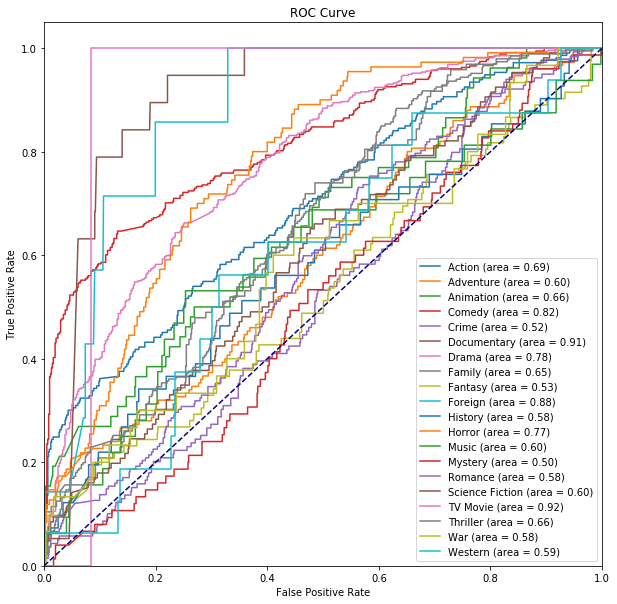

In [29]:
plt.figure(figsize=(10, 10))
for i in range(len(mlb.classes_)):
    plt.plot(fpr[i], tpr[i], label='{} (area = {:.2f})'.format(mlb.classes_[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [30]:
mlb.classes_

array(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'TV Movie', 'Thriller', 'War', 'Western'], dtype=object)

In [31]:
# for d in zip(predicted, np.array(test_labels)):
#     print('Predicted:{}, ground truth:{}'.format(d[0], d[1]))